In [24]:
import os
import shutil

img_rows = 137
img_cols = 236
color_type = 1
batch_size=256
epochs=300
subject='Bengali'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"imgs")
data_path=os.path.join(main_path,"Data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,subject+"200528.pt")
file_best=os.path.join(saved_path,subject+"200527.pt")

train_img_pkl=os.path.join(data_path,"train_data_ch3.npy")
test_img_pkl=os.path.join(data_path,"test_data_ch3.npy")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")


E:\kaggle_imgs\Bengali
E:\kaggle_imgs\Bengali\imgs
E:\kaggle_imgs\Bengali\saved_models
E:\kaggle_imgs\Bengali\Data


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

## Data Load

In [3]:
def read_train_info():
    fp=train_info_pkl
    if os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        df_train["id"]=df_train["image_id"].apply(lambda x : int(x.split("_")[1]))        
        X=df_train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,0]
        y=df_train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,1:]
        mskf=MultilabelStratifiedKFold(n_splits=6,random_state=22)        
        df_train["fold"]=-1
        sum=0
        for i, (trn_idx,vld_idx) in enumerate(mskf.split(X,y)):
            df_train.loc[vld_idx,"fold"]=i
            sum+=len(vld_idx)
            print("train",len(trn_idx),"valid",len(vld_idx))
        print('save train data to csv',"sum",sum,"total",len(df_train), flush=True)
        df_train.to_csv(train_info_pkl,index=False)
        
    trn_fold=[i for i in range(6) if i not in [5]]
    vld_fold=[5]
    trn_idx=df_train.loc[df_train["fold"].isin(trn_fold)].index
    vld_idx=df_train.loc[df_train["fold"].isin(vld_fold)].index
        
    return df_train, trn_idx, vld_idx
df_train, trn_idx, vld_idx=read_train_info()

loading train data from csv
complete!


In [4]:
# f,ax=plt.subplots(figsize=(10,30))
# sns.countplot(y=df_train.grapheme_root)

In [5]:
# f,ax=plt.subplots(figsize=(10,10))
# sns.countplot(y=df_train.vowel_diacritic)

In [6]:
all_img=[]
all_lbl=[]
def read_img():
    fp=train_img_pkl
    if os.path.exists(fp+"0.npz"):
        try:
            for i in range(4):
                f=np.load(fp+"{}.npz".format(i),allow_pickle=True)
                img_idx=f["lab"]
                img_arr=f["img"]
                all_img.append(np.array(img_arr))
                all_lbl.append(np.array(img_idx).reshape(-1,1))
                print(i,"load complete")
        except EOFError:
            print('EOFError raised.', flush=True)
    else:
        for i in range(4):
            img_parquet=img_path+"/train_image_data_{}.parquet".format(i)
            file=pd.read_parquet(img_parquet)
            print("{i} parquet read complete")
            img_idx=file.image_id.values
            img_arr=file.iloc[:,1:].values
            img_arr=img_arr.astype(np.uint8)
            print("{i} pandas to numpy complete")
            img_path_train=os.path.join(img_path,"train")
            np.savez(train_pickle+"{}".format(i),img=img_arr,lab=img_idx)
            print("{i} numpy save complete")
            all_img.append(img_arr)
            all_lbl.append(img_idx)
            
    train_all_img=np.vstack(all_img)
    train_all_lbl=np.vstack(all_lbl)
    return train_all_img,train_all_lbl

train_all_img,train_all_lbl = read_img()

0 load complete
1 load complete
2 load complete
3 load complete


## Define Dataset

In [7]:
from torch.utils.data import Dataset
class BengaliDataset(Dataset):
    def __init__(self,csv,rows,cols,tr):
        self.csv=csv.reset_index()
        self.img_ids=csv["id"].values
        self.img_rows=rows
        self.img_cols=cols
        self.tr=tr
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,index):
        img_id=self.img_ids[index]
        img=train_all_img[img_id]
        img=255-img
        img=img.reshape(img_rows,img_cols,color_type)
        img=np.repeat(img,3,2)
        
#         if self.tr is not None:
#             img=self.tr(image=img)["image"]
        if self.tr is not None:
            img=self.tr(img)
        
        lbl1=self.csv.iloc[index].grapheme_root
        lbl2=self.csv.iloc[index].vowel_diacritic
        lbl3=self.csv.iloc[index].consonant_diacritic
        
        return img,np.array([lbl1,lbl2,lbl3])
#         return (torch.tensor(img,dtype=torch.float).permute(2,0,1),torch.tensor(lbl1,dtype=torch.long),
#                 torch.tensor(lbl2,dtype=torch.long),torch.tensor(lbl3,dtype=torch.long))
    


## Image Augmentation

In [8]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, HorizontalFlip, Normalize
)
from albumentations.pytorch import ToTensor, ToTensorV2

## Albumentation

In [9]:
train_transforms= Compose([
    Rotate(20),
#     OneOf([
#         IAAAdditiveGaussianNoise(),
#         GaussNoise(),
#     ], p=0.2),
#     OneOf([
#         MotionBlur(p=0.2),
#         MedianBlur(blur_limit=3, p=0.1),
#         Blur(blur_limit=3, p=0.1),
#     ], p=0.2),
#     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#         IAAPiecewiseAffine(p=0.3),
#     ], p=0.2),
#     OneOf([
#         CLAHE(clip_limit=2),
#         IAASharpen(),
#         IAAEmboss(),
#         RandomBrightnessContrast(),
#     ], p=0.3),
#     HueSaturationValue(p=0.3),
    ToTensor()
])
valid_transforms=Compose([
    ToTensor()
])

## Image Augmentation[PyTorch]

In [10]:
from torchvision.transforms import transforms
train_torch_transforms=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(20,translate=(0.15,0.15)),
    transforms.ToTensor()
])
valid_torch_transforms=transforms.Compose([
    transforms.ToTensor()
])

## Data Loader

In [11]:
from torch.utils.data import Dataset,DataLoader

In [12]:
trn_dataset=BengaliDataset(csv=df_train.loc[trn_idx],
                           rows=img_rows,cols=img_cols,
                           tr=train_torch_transforms)
vld_dataset=BengaliDataset(csv=df_train.loc[vld_idx],
                           rows=img_rows,cols=img_cols,
                           tr=valid_torch_transforms)

In [13]:
trn_loader=DataLoader(trn_dataset, shuffle=True,batch_size=batch_size)
vld_loader=DataLoader(vld_dataset, shuffle=False,batch_size=batch_size)

In [14]:
# for inputs,targets in trn_loader:
#     break
#inputs.shape
#targets.shape

## Model

In [15]:
import torch
import pretrainedmodels
import torch.nn as nn

In [16]:
model_name="resnet34"
model=pretrainedmodels.__dict__[model_name](pretrained="imagenet")

In [17]:
in_features=model.last_linear.in_features
model.last_linear=nn.Linear(in_features,186)

In [18]:
model=model.cuda()

In [19]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode="max",
                                                     verbose=True,
                                                     patience=7,
                                                     factor=0.5)

## Train

In [20]:
from tqdm import tqdm_notebook
from sklearn.metrics import recall_score

In [21]:
best_score=0
model.load_state_dict(torch.load(file_best))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
for epoch in range(epochs):    
    trn_loss=[]
    model.train()
    for inputs,targets in tqdm_notebook(trn_loader):
        inputs=inputs.cuda()
        targets=targets.cuda()

        logits=model(inputs)

        grapheme = logits[:,:168]
        vowel=logits[:,168:179]
        cons=logits[:,179:]

        loss = loss_fn(grapheme,targets[:,0]) +  loss_fn(vowel,targets[:,1]) +  loss_fn(cons,targets[:,2])

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        trn_loss.append(loss.item())


    val_loss=[]
    val_true=[]
    val_pred=[]

    with torch.no_grad():
        for inputs, targets in tqdm_notebook(trn_loader):
            inputs=inputs.cuda()
            targets=targets.cuda()

            logits=model(inputs)
 
            grapheme = logits[:,:168]
            vowel=logits[:,168:179]
            cons=logits[:,179:]

            loss = 0.5*loss_fn(grapheme,targets[:,0]) +  0.25*loss_fn(vowel,targets[:,1]) +  0.25*loss_fn(cons,targets[:,2])

            val_loss.append(loss.item())


            grapheme=grapheme.cpu().argmax(dim=1).data.numpy()
            vowel=vowel.cpu().argmax(dim=1).data.numpy()
            cons=cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme,vowel,cons],axis=1))

    val_true=np.concatenate(val_true)
    val_pred=np.concatenate(val_pred)

    val_loss=np.mean(val_loss)
    trn_loss=np.mean(trn_loss)

    score_g=recall_score(val_true[:,0],val_pred[:,0],average="macro")
    score_v=recall_score(val_true[:,1],val_pred[:,1],average="macro")
    score_c=recall_score(val_true[:,2],val_pred[:,2],average="macro")

    final_score=np.average([score_g,score_v,score_c],weights=[2,1,1])
    print("train_loss:","%.5f"%trn_loss,"valid_loss:","%.5f"%val_loss)

    if final_score>best_score:
        best_score=final_score
        state_dict=model.cpu().state_dict()
        model=model.cuda()
        torch.save(state_dict,file_path)
                
                

C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train_loss: 0.53313 valid_loss: 0.16773



train_loss: 0.41840 valid_loss: 0.14411


KeyboardInterrupt: 

## Load Test Data

In [ ]:
all_img=[]
all_lbl=[]
def read_test_img():
    fp=test_img_pkl
    if os.path.exists(fp+"0.npz"):
        try:
            for i in range(4):
                f=np.load(fp+"{}.npz".format(i),allow_pickle=True)
                img_idx=f["lab"]
                img_arr=f["img"]
                all_img.append(np.array(img_arr))
                all_lbl.append(np.array(img_idx).reshape(-1,1))
                print(i,"load complete")
        except EOFError:
            print('EOFError raised.', flush=True)
    else:
        for i in range(4):
            img_parquet=img_path+"/test_image_data_{}.parquet".format(i)
            file=pd.read_parquet(img_parquet)
            print("{i} parquet read complete")
            img_idx=file.image_id.values
            img_arr=file.iloc[:,1:].values
            img_arr=img_arr.astype(np.uint8)
            print("{i} pandas to numpy complete")
            img_path_train=os.path.join(img_path,"train")
            np.savez(train_pickle+"{}".format(i),img=img_arr,lab=img_idx)
            print("{i} numpy save complete")
            all_img.append(img_arr)
            all_lbl.append(img_idx)
            break
            
    train_all_img=np.vstack(all_img)
    train_all_lbl=np.vstack(all_lbl)
    return train_all_img,train_all_lbl

train_all_img,train_all_lbl = read_img()

In [38]:
img_parquet=img_path+"/test_image_data_1.parquet"
file=pd.read_parquet(img_parquet)
print(" parquet read complete")
img_idx=file.image_id.values
img_arr=file.iloc[:,1:].values
img_arr=img_arr.astype(np.uint8)
print(" pandas to numpy complete")
#np.savez(test_img_pkl+"{}".format(i),img=img_arr,lab=img_idx)


 parquet read complete
 pandas to numpy complete


In [30]:
img_idx

array(['Test_0', 'Test_1', 'Test_2'], dtype=object)

In [32]:
img_arr.shape

(3, 32332)

In [39]:
file

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Test_3,199,227,236,241,238,242,245,243,243,...,222,222,226,224,222,227,220,208,194,136
1,Test_4,243,246,251,252,251,249,250,250,251,...,251,252,252,252,252,253,253,253,253,253
2,Test_5,251,250,250,251,252,254,252,251,251,...,253,253,252,252,252,253,252,249,248,249


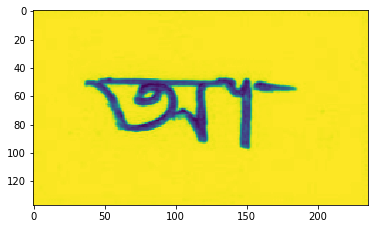

In [36]:
plt.imshow(img_arr[0].reshape(img_rows,img_cols))

In [37]:
img_rows*img_cols

32332